In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 

!pip install -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 3.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=99e8b683dbe52b55c322edf85092a8b3884949239b6408ad40f7ec6d45bf2eb2
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=f05cb574a020d23ecde56e43d58ae7ab38239f4e39f8dfedd479ede8b3ada5b2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
#----------------------#

In [2]:
# Using images stored on Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/Data"

Data_augmentation  Images_few_10  Images_few_50  Images_split  README.txt


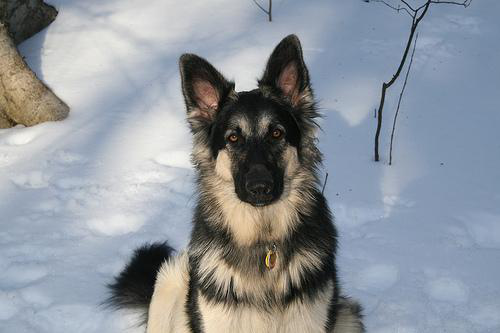

In [ ]:
# Test -> show an image from the dataset
# Format = PIL
keras.preprocessing.image.load_img("/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/Data/Images_few_10/train/German_shepherd/n02106662_590.jpg")

In [ ]:
#----------------------#

In [ ]:
# Dataset generation (train, validation et test)

# In order to train the model faster,
# we will use 10 dog breeds
# and resize the image -> 150x150

path_google_drive = "/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/Data/"

batch_size_ = 10
IMG_SIZE_ = 150

# Data augmentation:
# only for the train set
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,  # normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,  # normalization
    validation_split=0
)

# Train set:
path = path_google_drive + "Images_few_10/train/"

x_train = datagen_train.flow_from_directory(
    path,
    target_size=(IMG_SIZE_, IMG_SIZE_), # resizing
    batch_size=batch_size_,
    class_mode="categorical",
    shuffle=True,
    seed=0,
    subset='training'
)

# Validation set:
path = path_google_drive + "Images_few_10/val/"

x_val = test_datagen.flow_from_directory(
    path,
    batch_size=batch_size_,
    class_mode="categorical",
    target_size=(IMG_SIZE_, IMG_SIZE_), # resizing
    seed=0,
    subset='training'
)

# Test set:
path = path_google_drive + "Images_few_10/test/"

x_test = test_datagen.flow_from_directory(
    path,
    batch_size=batch_size_,
    class_mode="categorical",
    target_size=(IMG_SIZE_, IMG_SIZE_), # resizing
    seed=0,
    subset='training'
)

Found 1025 images belonging to 10 classes.
Found 338 images belonging to 10 classes.
Found 350 images belonging to 10 classes.


In [ ]:
#----------------------#

In [ ]:
# In order to get the first parts of our CNN,
# we will compare two architectures :
# one inspired by AlexNet,
# the other one inspired by VGG16

In [ ]:
nbr_class = 10
IMG_SIZE_ = 150

def build_model_AlexNet():
  input_ = keras.layers.Input(shape=(IMG_SIZE_, IMG_SIZE_, 3))

  x = keras.layers.Conv2D(96, 11, activation="relu", padding="same")(input_)
  x = keras.layers.MaxPool2D(2)(x)

  x = keras.layers.Conv2D(256, 5, activation="relu", padding="same")(x)
  x = keras.layers.MaxPool2D(2)(x)

  x = keras.layers.Conv2D(384, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(384, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = keras.layers.MaxPool2D(2)(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(4096, activation="relu")(x)
  x = keras.layers.Dense(4096, activation="relu")(x)

  output_ = keras.layers.Dense(nbr_class, activation="softmax")(x)

  model = keras.Model(inputs=[input_], outputs=[output_])

  model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
  )

  return(model)

In [ ]:
nbr_class = 10
IMG_SIZE_ = 150

def build_model_VGG():
  input_ = keras.layers.Input(shape=(IMG_SIZE_, IMG_SIZE_, 3))

  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(input_)
  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

  x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(512, 3, padding="same", activation="relu")(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(4096, activation="relu")(x)
  x = keras.layers.Dense(4096, activation="relu")(x)

  output_ = keras.layers.Dense(nbr_class, activation="softmax")(x)

  model = keras.Model(inputs=[input_], outputs=[output_])

  model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
  )

  return(model)

In [ ]:
#----------------------#

In [ ]:
model_test_1 = build_model_AlexNet()

model_test_1.fit(
      x_train,
      epochs=1000,
      validation_data=x_val,
      callbacks=[keras.callbacks.EarlyStopping(patience=3)]
  )

Epoch 1/1000
103/103 [==============================] - 15s 131ms/step - loss: 2.3077 - accuracy: 0.1166 - val_loss: 2.2990 - val_accuracy: 0.1391
Epoch 2/1000
103/103 [==============================] - 13s 122ms/step - loss: 2.2993 - accuracy: 0.1397 - val_loss: 2.2987 - val_accuracy: 0.1391
Epoch 3/1000
103/103 [==============================] - 13s 121ms/step - loss: 2.2966 - accuracy: 0.1537 - val_loss: 2.2904 - val_accuracy: 0.1391
Epoch 4/1000
103/103 [==============================] - 12s 120ms/step - loss: 2.2971 - accuracy: 0.1402 - val_loss: 2.2950 - val_accuracy: 0.1391
Epoch 5/1000
103/103 [==============================] - 13s 122ms/step - loss: 2.2941 - accuracy: 0.1435 - val_loss: 2.2892 - val_accuracy: 0.1391
Epoch 6/1000
103/103 [==============================] - 12s 120ms/step - loss: 2.2885 - accuracy: 0.1597 - val_loss: 2.2922 - val_accuracy: 0.1391
Epoch 7/1000
103/103 [==============================] - 12s 120ms/step - loss: 2.2933 - accuracy: 0.1391 - val_loss: 2

In [ ]:
model_test_2 = build_model_VGG()

model_test_2.fit(
      x_train,
      epochs=1000,
      validation_data=x_val,
      callbacks=[keras.callbacks.EarlyStopping(patience=3)]
  )

Epoch 1/1000
103/103 [==============================] - 15s 126ms/step - loss: 2.3006 - accuracy: 0.1212 - val_loss: 2.2924 - val_accuracy: 0.1391
Epoch 2/1000
103/103 [==============================] - 12s 114ms/step - loss: 2.2913 - accuracy: 0.1426 - val_loss: 2.2941 - val_accuracy: 0.1391
Epoch 3/1000
103/103 [==============================] - 12s 114ms/step - loss: 2.2986 - accuracy: 0.1345 - val_loss: 2.2924 - val_accuracy: 0.1391
Epoch 4/1000
103/103 [==============================] - 12s 117ms/step - loss: 2.2998 - accuracy: 0.1241 - val_loss: 2.2916 - val_accuracy: 0.1391
Epoch 5/1000
103/103 [==============================] - 12s 115ms/step - loss: 2.2916 - accuracy: 0.1436 - val_loss: 2.2918 - val_accuracy: 0.1391
Epoch 6/1000
103/103 [==============================] - 12s 115ms/step - loss: 2.2937 - accuracy: 0.1389 - val_loss: 2.2915 - val_accuracy: 0.1391
Epoch 7/1000
103/103 [==============================] - 12s 117ms/step - loss: 2.2933 - accuracy: 0.1276 - val_loss: 2

In [ ]:
model_test_1.evaluate(x_test, verbose=1)

35/35 [==============================] - 172s 5s/step - loss: 2.1334 - accuracy: 0.2086


In [ ]:
model_test_2.evaluate(x_test, verbose=1)

35/35 [==============================] - 2s 47ms/step - loss: 2.2906 - accuracy: 0.1400


In [ ]:
'''
AlexNet seems to be a good start in order to build our own CNN.
'''

In [ ]:
#----------------------#

In [ ]:
# In order to get better regularization, we are adding dropout layers.
# Besides, l2 regularization is used with the fully connected layers.

# We are using keras tuner to find interesting hyperparameters values.

In [ ]:
nbr_class = 10
IMG_SIZE_ = 150

def build_model_10_dogs(hp):
  input_ = keras.layers.Input(shape=(IMG_SIZE_, IMG_SIZE_, 3))

  #----------------------#

  x = keras.layers.experimental.preprocessing.RandomCrop(IMG_SIZE_, IMG_SIZE_, seed=0)(input_)

  #----------------------#

  x = keras.layers.Conv2D(
        filters=hp.Choice(
                    'filter1_value',
                    values=[64, 96, 128],
                    default=96
                ),
        kernel_size=hp.Choice(
                      'kernel1_value',
                      values=[7, 11, 15],
                      default=11
                    ),
        padding="same",
        use_bias=False
      )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.MaxPool2D(2)(x)

  #----------------------#

  x = keras.layers.Conv2D(
        filters=hp.Choice(
                    'filter2_value',
                    values=[64, 128, 256],
                    default=256
                ),
        kernel_size=3,
        padding="same", 
        use_bias=False
      )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.MaxPool2D(2)(x)

  #----------------------#

  x = keras.layers.Conv2D(
        filters=hp.Choice(
                    'filter3_value',
                    values=[64, 128, 256],
                    default=256
                ),
        kernel_size=3,
        padding="same", 
        use_bias=False
      )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  x = keras.layers.Conv2D(
        filters=hp.Choice(
                    'filter4_value',
                    values=[128, 256, 384],
                    default=256
                ),
        kernel_size=3,
        padding="same", 
        use_bias=False
      )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  x = keras.layers.Conv2D(
        filters=hp.Choice(
                    'filter5_value',
                    values=[64, 128, 256],
                    default=256
                ),
        kernel_size=3,
        padding="same", 
        use_bias=False
      )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.MaxPool2D(2)(x)

  #----------------------#

  x = keras.layers.Flatten()(x)

  hp_units1 = hp.Int('units1', min_value=1024, max_value=4096, step=1024)
  x = keras.layers.Dense(units=hp_units1, use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  #----------------------#

  x = keras.layers.Dropout(
        rate=hp.Choice(
                  'rate1_value',
                  values=[0.3, 0.4, 0.5],
                  default=0.4
        )
      )(x)

  #----------------------#

  hp_units2 = hp.Int('units2', min_value=1024, max_value=4096, step=1024)
  x = keras.layers.Dense(units=hp_units2, use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  #----------------------#

  x = keras.layers.Dropout(
        rate=hp.Choice(
                  'rate2_value',
                  values=[0.3, 0.4, 0.5],
                  default=0.4
        )
      )(x)
  
  #----------------------#

  output_ = keras.layers.Dense(nbr_class, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.1))(x)

  #----------------------#

  model = keras.Model(inputs=[input_], outputs=[output_])

  #----------------------#

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3])
  model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=["accuracy"]
  )

  #----------------------#

  return(model)

In [ ]:
# We don't want to use a grid search, because it is too slow for our CNN.
# Instead, we will use a bayesian optimization.

tuner_bayesian = kt.BayesianOptimization(
    build_model_10_dogs,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    seed=0,
    overwrite=True
)

In [ ]:
# We are using few epochs.
# The goal is to find the trends of these hyparameters.
n_epochs = 30

tuner_bayesian.search(
    x_train,
    validation_data=x_val,
    epochs=n_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

Trial 2 Complete [00h 12m 07s]
val_accuracy: 0.3535503000020981

Best val_accuracy So Far: 0.3535503000020981
Total elapsed time: 00h 17m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# These are the hyperparameters values:
best_hyperparameters = tuner_bayesian.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

{'filter1_value': 64, 'kernel1_value': 7, 'filter2_value': 256, 'filter3_value': 64, 'filter4_value': 256, 'filter5_value': 64, 'units1': 2048, 'rate1_value': 0.4, 'units2': 2048, 'rate2_value': 0.4, 'learning_rate': 0.0001}


In [ ]:
# It will give us this CNN:
best_model = tuner_bayesian.get_best_models(num_models=1)[0]
print(best_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 256)       147456

In [ ]:
#----------------------#

In [ ]:
# Now we can use these hyperparameters and train our CNN

In [ ]:
model = tuner_bayesian.hypermodel.build(best_hyperparameters)

In [ ]:
# We will use two callbacks :
# early stopping -> in order to avoid overfitting
# tensorboard_cb -> it will record some informations inside logs,
# it will be used by TensorBoard

# Early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# TensorBoard
root_logdir = "/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/logs/"

def get_run_logdir():    
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return(os.path.join(root_logdir, run_id))

tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

In [ ]:
# Training of the model
# epochs is very high because we are using an early stopping callback
# -> we don't need to focus on the number of epochs, because early stopping will
# stop the model before it will overfit.

history = model.fit(
  x_train,
  epochs=1000,
  batch_size=batch_size_,
  validation_data=x_val,
  callbacks=[early_stopping_cb, tensorboard_cb]
)

Epoch 1/1000
103/103 [==============================] - 14s 123ms/step - loss: 61.9381 - accuracy: 0.1277 - val_loss: 59.5830 - val_accuracy: 0.0976
Epoch 2/1000
103/103 [==============================] - 12s 114ms/step - loss: 58.5677 - accuracy: 0.2263 - val_loss: 57.4095 - val_accuracy: 0.1006
Epoch 3/1000
103/103 [==============================] - 12s 115ms/step - loss: 55.2810 - accuracy: 0.2301 - val_loss: 53.4058 - val_accuracy: 0.1450
Epoch 4/1000
103/103 [==============================] - 12s 113ms/step - loss: 51.8972 - accuracy: 0.2481 - val_loss: 50.2504 - val_accuracy: 0.1450
Epoch 5/1000
103/103 [==============================] - 12s 113ms/step - loss: 48.6107 - accuracy: 0.2589 - val_loss: 45.9753 - val_accuracy: 0.2692
Epoch 6/1000
103/103 [==============================] - 12s 113ms/step - loss: 45.1712 - accuracy: 0.2984 - val_loss: 42.9391 - val_accuracy: 0.2663
Epoch 7/1000
103/103 [==============================] - 12s 113ms/step - loss: 42.0350 - accuracy: 0.2788 

In [ ]:
# Saving the model
model.save("/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/dogs_classification_10_optimisation_08042021.h5")

In [ ]:
loss, acc = model.evaluate(x_train, verbose=0)
print("Train set: ")
print("loss: ", loss)
print("accuracy: ", acc)

Train set: 
loss:  2.679717540740967
accuracy:  0.6370731592178345


In [ ]:
loss, acc = model.evaluate(x_val, verbose=0)
print("Validation set: ")
print("loss: ", loss)
print("accuracy: ", acc)

Validation set: 
loss:  3.3096959590911865
accuracy:  0.4497041404247284


In [ ]:
loss, acc = model.evaluate(x_test, verbose=0)
print("Test set: ")
print("loss: ", loss)
print("accuracy: ", acc)

Test set: 
loss:  3.362010955810547
accuracy:  0.43714284896850586


In [ ]:
'''
We build a CNN, which reach 43.71% accuracy on the test set (10 dog breeds).
'''

In [ ]:
#----------------------#

In [ ]:
# Visualization using TensorBoard

In [3]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir "/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/logs/"

In [ ]:
'''
!tensorboard dev upload \
  --logdir "/content/drive/MyDrive/Gaetan_Travail/ML/Formation_OC_IML/P6/Projet/logs/" \
  --name "CNN from scratch" \
  --description "TensorBoard visualization" \
  --one_shot
'''